## directory setting

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# 디렉토리 설정
resources = ''  ## 각자 저장공간

import os
os.chdir(resources)

# install&import modules

In [3]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm
# !pip install sentencepiece
# !pip install transformers==3.0.2

In [4]:
#깃허브에서 KoBERT 파일 로드 (pre-trained model)
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-xl7d7a8g
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-xl7d7a8g
     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 344 kB 42.3 MB/s 
     |████████████████████████████████| 47.3 MB 1.2 MB/s 
     |████████████████████████████████| 4.5 MB 50.0 MB/s 
     |████████████████████████████████| 1.2 MB 55.0 MB/s 
     |████████████████████████████████| 3.8 MB 34.3 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 6.5 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 8.6 MB 56.0 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
  Created wheel for kobert: filename=kobe

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
# 시각화
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

# 분석
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict # defaultdict(list)
from textwrap import wrap

In [8]:
#GPU 사용
device = torch.device("cuda:0")

In [9]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/drive/MyDrive/Colab Notebooks/공모전/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/Colab Notebooks/공모전/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


# import data

In [10]:
import pandas as pd
data = pd.read_csv('1. 실습용자료.txt', sep = '|',encoding='cp949')

# Preprocessing

In [11]:
data.info()
# data.isna().any().any()
# data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932348 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB


In [12]:
16677/1000000*100

1.6677000000000002

In [13]:
df =data.copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932348 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB


# encoding the labels

In [15]:
labels = sorted(df.digit_1.unique())

label_dict = {}
for index, labels in enumerate(labels):
  label_dict[labels] = index
label_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18}

In [16]:
df['labels'] = df.digit_1.replace(label_dict)

In [17]:
len(df.labels.unique())

19

In [18]:
df = df.astype('str')
# 독립변수 생성; ' ' 로 분리하여 합쳐줌.
df['text'] = df['text_obj']+' '+df['text_mthd']+' '+df['text_deal']
df.text

0               카센터에서 자동차부분정비 타이어오일교환
1             상점내에서 일반인을 대상으로 채소.과일판매
2         절단하여사업체에도매 공업용고무를가지고 합성고무도매
3                영업점에서 일반소비자에게 열쇠잠금장치
4            어린이집 보호자의 위탁을 받아 취학전아동보육
                     ...             
999995                  제품입고 워싱 청바지워싱
999996           현장에서 고객의요청에의해 실내인테리어
999997          영업점에서 일반소비자에게 여성의류 판매
999998           사업장에서 일반고객을대상으로 필라테스
999999      사업장에서 접객시설을 갖추고 한식(미역구)판매
Name: text, Length: 1000000, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label')

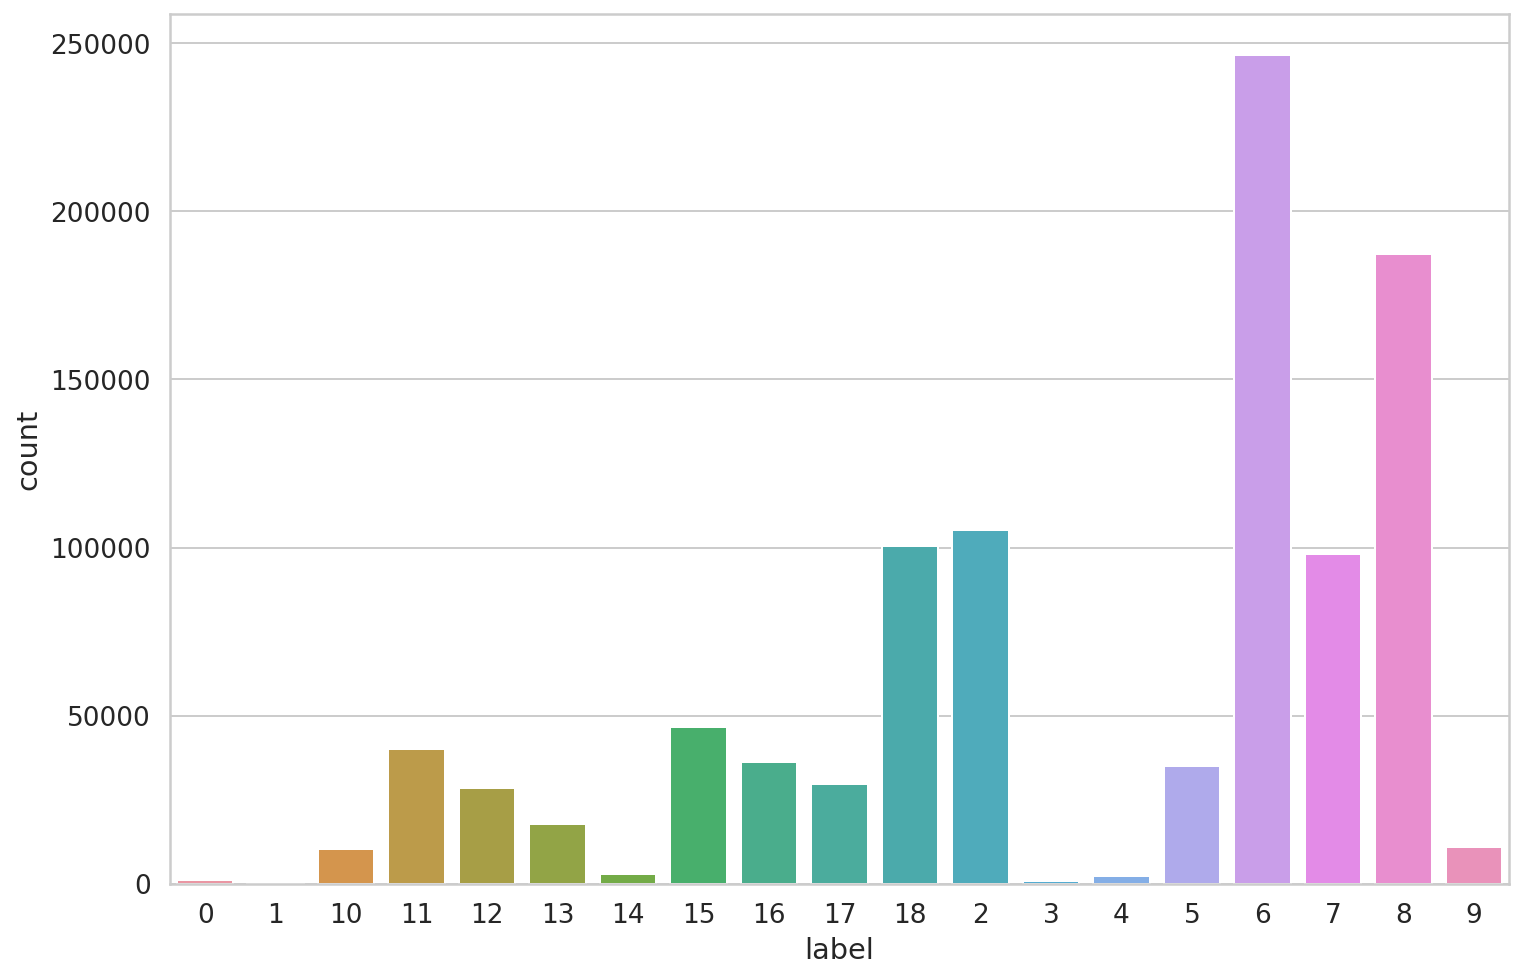

In [19]:
sns.countplot(sorted(df.labels))
plt.xlabel('label')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  object
 3   digit_3    1000000 non-null  object
 4   text_obj   1000000 non-null  object
 5   text_mthd  1000000 non-null  object
 6   text_deal  1000000 non-null  object
 7   labels     1000000 non-null  object
 8   text       1000000 non-null  object
dtypes: object(9)
memory usage: 68.7+ MB


In [21]:
# check string nan => result is none
for idx, text in enumerate(df.text):
  if text =='' or pd.isnull(text):
    print(idx)

In [22]:
# 실제 사용 데이터 총 3만개
df_sam = df.sample(frac=0.03, random_state=123)

In [23]:
len(df_sam)

20000

In [24]:
df_list = []

for q, label in zip(df_sam['text'],df_sam['labels']):
  data = []
  data.append(q)
  data.append(str(label))

  df_list.append(data)


In [25]:
len(df_list)

20000

# Dataset Split

In [26]:
#train : test = 8:2 롤 data set 나누기

from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(df_list, test_size=0.20, random_state=123)

In [27]:
print(len(dataset_train))
print(len(dataset_test))

16000
4000


# KoBert 입력 데이터로 만들기

In [28]:
# 학습할 때 사용할 데이터셋 클래스 선언
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

## hyperparameter 
BERT authors recommendations for fine-tuning: 
- batch size: 16, 32
- learning rate(Adam) : 5e-5, 3e-5, 2e-5
- number of epochs: 2,3,4
we are going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.


In [29]:
# Setting parameters # 최대 길이는 64 


max_len = 64
batch_size = 16
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  2e-5

In [30]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False) 

using cached model. /content/drive/MyDrive/Colab Notebooks/공모전/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [31]:

#BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [32]:
data_train[0] # 첫번째 : 패딩된 시퀀스; 두 번재 : 길이와 타입에 대한 내용 ; 세번째는 어텐션 마스크 시퀀스. 
# 어텐션 마스크는 bert에 데이터가 입력되었을 때 어텐션 함수가 적용되어 연산이 된다. 이때 1로 패딩된 값들은 연산할 필요가 없기 때문에 연산을 하지 않아도 된다고 알려주는 데이터가 있어야 하는데 그게 바로 어텐션 마스크 시퀀스. 이렇게 bert나 kobert에는 어텐션 마스크 데이터도 함께 입력되어야함.

(array([   2, 3006, 7067, 7220, 6903,  994, 5816, 7078,  517, 6624, 5439,
        5561,  517,   54, 1761, 7321, 5561, 7689,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(19, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 6)

In [33]:
# torch 형식의 dataset 만들기
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# KoBERT 학습모델 만들기

In [34]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=19,   ##label 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)


        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    # mask
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()
    # forward
    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)

            
        return self.classifier(out)

In [35]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# apply softmax function to get the prediected probabilites 
# F.softmax(model(input_ids, attention_mask),dim = 1)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# KoBERT 모델 학습시키기

In [36]:
from tqdm.notebook import tqdm

# train & test 결과 저장 
results = defaultdict(list)
best_accuracy = 0
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    results['train_acc'].append((train_acc / (batch_id+1)))

    model.eval()   
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    

    
    results['test_acc'].append((test_acc / (batch_id+1)))
    
 


    #lr=5e-5 : 0.939
    #lr=1e-5 : 0.939; epoch: 7 -> 8부터는 오히려 test accuracy 가 줄어드는 현상 봄.
    # batchsize 가 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.919874668121338 train acc 0.125
epoch 1 batch id 201 loss 2.103497266769409 train acc 0.1828358208955224
epoch 1 batch id 401 loss 1.0020794868469238 train acc 0.3871571072319202
epoch 1 batch id 601 loss 0.7460076212882996 train acc 0.5351497504159733
epoch 1 batch id 801 loss 1.0767229795455933 train acc 0.6226591760299626
epoch 1 train acc 0.68175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 1 test acc 0.92225


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.2818511724472046 train acc 0.9375
epoch 2 batch id 201 loss 0.10255757719278336 train acc 0.9231965174129353
epoch 2 batch id 401 loss 0.08287498354911804 train acc 0.9292394014962594
epoch 2 batch id 601 loss 0.6087912321090698 train acc 0.9351081530782029
epoch 2 batch id 801 loss 0.41709616780281067 train acc 0.9381242197253433
epoch 2 train acc 0.9425625


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 2 test acc 0.95075


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.05124432593584061 train acc 1.0
epoch 3 batch id 201 loss 0.015122932381927967 train acc 0.9592661691542289
epoch 3 batch id 401 loss 0.0051552532240748405 train acc 0.9633728179551122
epoch 3 batch id 601 loss 0.32509249448776245 train acc 0.9651622296173045
epoch 3 batch id 801 loss 0.4136190116405487 train acc 0.9656679151061174
epoch 3 train acc 0.9681875


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 3 test acc 0.95875


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.011825593188405037 train acc 1.0
epoch 4 batch id 201 loss 0.00851841364055872 train acc 0.9779228855721394
epoch 4 batch id 401 loss 0.0036715264432132244 train acc 0.9808291770573566
epoch 4 batch id 601 loss 0.24166278541088104 train acc 0.9825291181364393
epoch 4 batch id 801 loss 0.08956421911716461 train acc 0.982599875156055
epoch 4 train acc 0.9833125


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 4 test acc 0.95875


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.00754582230001688 train acc 1.0
epoch 5 batch id 201 loss 0.003840996418148279 train acc 0.9866293532338308
epoch 5 batch id 401 loss 0.0023485689889639616 train acc 0.9887780548628429
epoch 5 batch id 601 loss 0.09489701688289642 train acc 0.9897046589018302
epoch 5 batch id 801 loss 0.09369923174381256 train acc 0.989856429463171
epoch 5 train acc 0.99


  0%|          | 0/250 [00:00<?, ?it/s]

epoch 5 test acc 0.95875


# accuracy 시각화

In [37]:
results

defaultdict(list,
            {'test_acc': [0.92225, 0.95075, 0.95875, 0.95875, 0.95875],
             'train_acc': [0.68175, 0.9425625, 0.9681875, 0.9833125, 0.99]})

(0.0, 1.0)

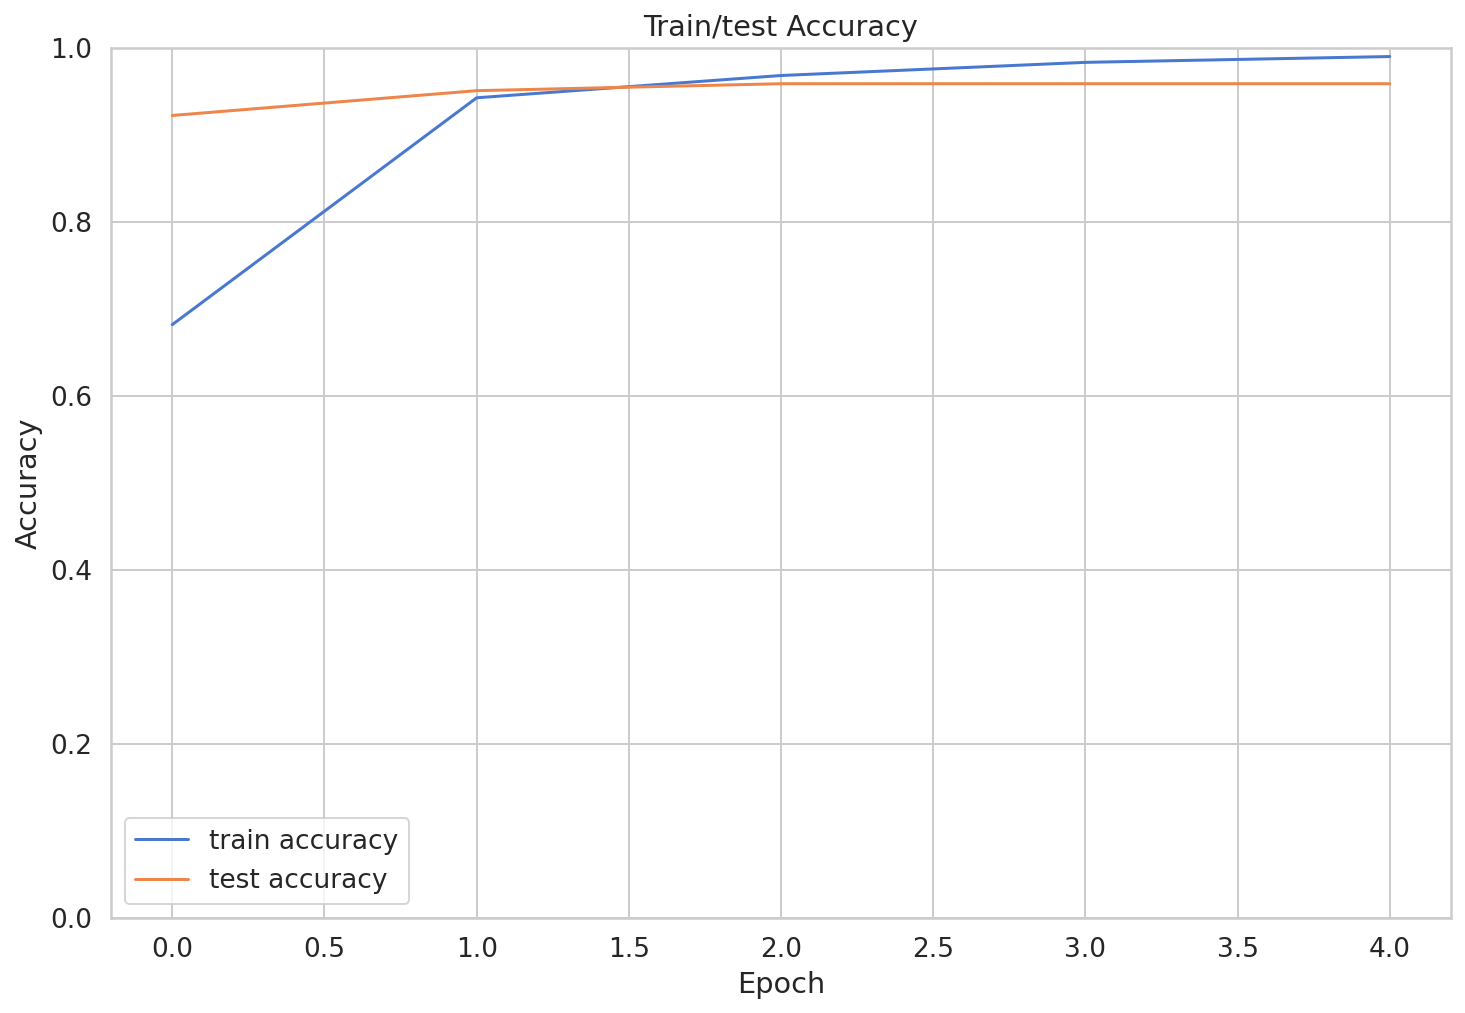

In [38]:
plt.plot(results['train_acc'], label = 'train accuracy')
plt.plot(results['test_acc'], label = 'test accuracy')

plt.title('Train/test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

# Classification report

In [39]:
def get_predictions(model, data_loader):
  model = model.eval() # 학습시 dropout 등의 관련 기능 stop

  text = []
  predictions = []
  prediction_probs = []
  real_values = []



  with torch.no_grad(): # 더이상 gradient tracking 하지 않도록 선언.
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        _, preds = torch.max(out,dim=1)
   

        # 리스트에 저장
        text.extend(token_ids)
        predictions.extend(preds)
        prediction_probs.extend(out)
        real_values.extend(label)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return text, predictions, prediction_probs, real_values

In [40]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
# d1 = pd.DataFrame(data = y_texts, columns='text')
# d2 = pd.DataFrame(data = y_pred, columns='y_pred')
# d3 = pd.DataFrame(data = y_pred_probs, columns='y_pred_probs')
# d4 = pd.DataFrame(data = y_test, columns='y_test')

# test_result = pd.concat([d1,d2,d3,d4],axis=1)
# test_result.to_csv('./test_result_BERT.csv',index=False)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         1
           2       0.93      0.93      0.93       384
           3       1.00      0.12      0.22         8
           4       0.50      0.67      0.57         6
           5       0.89      0.93      0.91       158
           6       0.98      0.96      0.97       958
           7       1.00      0.99      0.99       398
           8       0.97      1.00      0.98       729
           9       0.89      0.91      0.90        46
          10       0.98      0.98      0.98        43
          11       0.98      0.97      0.97       172
          12       0.86      0.91      0.88       108
          13       0.74      0.72      0.73        78
          14       0.92      0.79      0.85        14
          15       0.98      0.97      0.97       207
          16       0.99      0.97      0.98       160
          17       0.89    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='micro'))

0.95875


# 새로운 문장 테스트

In [55]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(sentence):
  data = [sentence, '0']
  dataset_another = [data]
  logits = 0
  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
  
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)

      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids)

      test_eval = []
      for i in out:
        logits = i
        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits)

        if np.argmax(logits) == 0:
          test_eval.append('농업,임업 및 어업, 대분류 : A')
        elif np.argmax(logits) == 1:
          test_eval.append('광업, 대분류: B')
        elif np.argmax(logits) == 2:
          test_eval.append('제조업,대분류:C')
        elif np.argmax(logits) == 3:
          test_eval.append('전기, 가스, 증기 및 공기 조절 공급업, 대분류:D')
        elif np.argmax(logits) == 4:
          test_eval.append('수도, 하수 및 폐기물 처리, 원료 재생업, 대분류:E')
        elif np.argmax(logits) == 5:
          test_eval.append('건설업, 대분류:F')
        elif np.argmax(logits) == 6:
          test_eval.append('도매 및 소매업, 대분류:G')
        elif np.argmax(logits) == 7:
          test_eval.append('운수 및 창고업, 대분류:H')
        elif np.argmax(logits) == 8:
          test_eval.append('숙박 및 음식점업, 대분류:I')
        elif np.argmax(logits) == 9:
          test_eval.append('정보통신업,대분류:J')
        elif np.argmax(logits) == 10:
          test_eval.append('금융 및 보험업','대분류:K')
        elif np.argmax(logits) == 11:
          test_eval.append('부동산업 , 대분류:L')
        elif np.argmax(logits) == 12:
          test_eval.append('전문, 과학 및 기술 서비스업, 대분류:M')
        elif np.argmax(logits) == 13:
          test_eval.append('사업시설 관리, 사업지원 및 임대 서비스업, 대분류:N')
        elif np.argmax(logits) == 14:
          test_eval.append('공공 행정, 국방 및 사회보장 행정 , 대분류:O')
        elif np.argmax(logits) == 15:
          test_eval.append('교육 서비스업, 대분류:P')
        elif np.argmax(logits) == 16:
          test_eval.append('보건업 및 사회복지 서비스업, 대분류:Q')
        elif np.argmax(logits) == 17:
          test_eval.append('예술, 스포츠 및 여가 관련 서비스업, 대분류:R')
        elif np.argmax(logits) == 18:
          test_eval.append('협회 및 단체, 수리 및 기타 개인 서비스업 ,대분류:S')
        elif np.argmax(logits) == 19:
          test_eval.append('가구 내 고용활동 및 달리 분류되지 않은 자가 소비 생산활동, 대분류:T')
        print('>> 해당 사업은 ' + test_eval[0] + ' 산업에 속합니다.')
        
        

  return logits

using cached model. /content/drive/MyDrive/Colab Notebooks/공모전/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [56]:
test_data = []
for i in range(len(dataset_test)):
  test_data.append(dataset_test[i][0])
test_data

['사업장 일반인대상 의료서비스',
 '사업장에서 고객의 요구에 따라 도장',
 '양조장 소매 막걸리판매',
 'nan 컴퓨터, 사무기기, 전산소모품 nan',
 '관리사무소 상가입주민대상 상가관리서비스',
 '음식점에서 접객시설을 갖추고 생선구이 판매',
 '영업장소에서 일반소비자에게 생화,꽃화분판매',
 '제과점에서 접객시설갖추고 빵,케익등 제공',
 '학원에서 초,중고생을 대상으로 수학교육',
 '구내에서 동원푸드 직원에게 구내식당',
 '용달화물자동차로 고객의 요청으로 화물운송서비스',
 '매장에서 일반 소비자에게 소매 북어,멸치',
 '사무실에서 의뢰를 받아 경영컨설팅,금융자문업',
 '치킨점에서 접객시설갖추고 치킨',
 '보험회사 일반대중을 대상으로 보험업무 수행',
 '플라스틱부품을 가지고 사출,성형하여 장비조립용 부분품 제조',
 '음식점에서 접객시설을갖추고 쌈밥',
 '미용실에서 일반인대상으로 파마,컷트',
 '고객의사업장에서 고객의요청에따라 고추건조기수리등',
 '매장에서 일반소비자에게 화장품판매',
 '방송제작 nan nan',
 '영업장에서 일반인대상으로 왁싱,반영구',
 '흥농종묘 각종농약을 갖추고 농약판매',
 '매장에서 접객시설을갖추고 맥주.소주',
 '생활용품 매장에서 일반소비자에게 생활잡화 소매',
 '점포에서 일반인대상 반찬소매',
 '사업장에서 의뢰를 받아 일반기계장비수리',
 '화훼 농장에서 시설재배 화훼 작물재배',
 '가게에서 고객요청에의해수선 청바지,티셔츠,모자',
 '매장에서 일반인을대상으로 여성의류판매',
 '음식점에서 접객시설을갖추고 근고기',
 '매장에서 고객의 요청에 따라 도배,장판 판매',
 '매장에서 의뢰를받아 한복수선',
 'PVC 반제품입고, 가공용접 nan',
 '용달화물자동차로 고객의 요청으로 화물운송서비스',
 '리빙텔에서 숙박시설을 갖추고 숙식제공',
 '의원에서 소아,청소년에게 진료',
 '학원에서 학원생대상으로 영어교육',
 '대리점 소매점으로 도매 우유 도매',
 '소매업자,산업사용자에게 매

In [ ]:
# 예측한 label 리스트에 저장
label_answer = []
step = 0
for i in tqdm(test_data):
  label_answer.append(predict(i))

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 운수 및 창고업, 대분류:H 산업에 속합니다.
>> 해당 사업은 교육 서비스업, 대분류:P 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 운수 및 창고업, 대분류:H 산업에 속합니다.
>> 해당 사업은 제조업,대분류:C 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 제조업,대분류:C 산업에 속합니다.
>> 해당 사업은 보건업 및 사회복지 서비스업, 대분류:Q 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 협회 및 단체, 수리 및 기타 개인 서비스업 ,대분류:S 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 운수 및 창고업, 대분류:H 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업, 대분류:I 산업에 속합니다.
>> 해당 사업은 제조업,대분류:C 산업에 속합니다.
>> 해당 사업은 교육 서비스업, 대분류:P 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 도매 및 소매업, 대분류:G 산업에 속합니다.
>> 해당 사업은 숙박 및 음식점업

In [58]:
label_answer

[16,
 5,
 8,
 6,
 11,
 8,
 6,
 8,
 15,
 8,
 7,
 6,
 12,
 8,
 10,
 2,
 8,
 18,
 2,
 6,
 9,
 18,
 6,
 8,
 6,
 6,
 2,
 0,
 18,
 6,
 8,
 5,
 18,
 2,
 7,
 8,
 16,
 15,
 6,
 6,
 6,
 18,
 16,
 7,
 5,
 18,
 6,
 8,
 13,
 6,
 6,
 13,
 8,
 6,
 8,
 6,
 15,
 8,
 17,
 17,
 17,
 7,
 6,
 8,
 6,
 2,
 8,
 18,
 8,
 6,
 18,
 8,
 6,
 6,
 7,
 18,
 6,
 8,
 16,
 6,
 9,
 6,
 17,
 8,
 15,
 18,
 17,
 12,
 15,
 6,
 13,
 2,
 17,
 8,
 15,
 6,
 6,
 8,
 8,
 8,
 6,
 16,
 6,
 6,
 6,
 6,
 17,
 17,
 8,
 18,
 15,
 6,
 8,
 15,
 7,
 5,
 8,
 8,
 8,
 15,
 18,
 13,
 11,
 15,
 17,
 6,
 16,
 6,
 12,
 2,
 8,
 6,
 7,
 6,
 6,
 6,
 7,
 7,
 2,
 2,
 16,
 8,
 2,
 8,
 7,
 2,
 2,
 6,
 18,
 6,
 2,
 13,
 18,
 8,
 18,
 6,
 11,
 8,
 6,
 15,
 7,
 6,
 16,
 7,
 2,
 8,
 7,
 18,
 6,
 9,
 8,
 2,
 6,
 6,
 8,
 15,
 13,
 18,
 8,
 2,
 7,
 8,
 17,
 11,
 11,
 6,
 16,
 7,
 6,
 8,
 12,
 8,
 16,
 18,
 11,
 6,
 7,
 6,
 7,
 6,
 6,
 8,
 7,
 2,
 11,
 18,
 18,
 17,
 12,
 15,
 12,
 6,
 6,
 6,
 6,
 15,
 7,
 5,
 18,
 11,
 8,
 8,
 16,
 2,
 6,
 6,
 7,
 6,
 6,
 6,
 5

In [59]:
#결과저장
answer = pd.DataFrame(label_answer)
answer.columns =['label_answer']
dataset_test_df = pd.DataFrame(data = dataset_test, columns=['text','labels'])
dataset_test_df.to_csv('./result_30000_16_5.csv',index=False)

In [63]:
dataset_test_df

,text,labels
0,사업장 일반인대상 의료서비스,16
1,사업장에서 고객의 요구에 따라 도장,5
2,양조장 소매 막걸리판매,6
3,"nan 컴퓨터, 사무기기, 전산소모품 nan",6
4,관리사무소 상가입주민대상 상가관리서비스,11
...,...,...
3995,영업장소에서 산업사용자에게 자동차부품도매,6
3996,"세라마이드,삼백초,유근피추출물 배합 조율하여(외주제조) 아토피보습제 제조",2
3997,"떡집에서 고객으로부터 주문받고 제공받은 쌀을 이용해 떡,참기름 등 제조",2
3998,부동산에서 계약및 체결에 의해 부동산중개서비스,11


In [64]:
#결과저장
df_concat = pd.concat([dataset_test_df, answer],axis=1)
df_concat.to_csv('./result_with_answer_30000_16_5.csv',index=False)

# log 만들기

In [44]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [45]:
formatter = logging.Formatter(u'%(asctime)s [%(levelname)8s] %(message)s')

In [46]:
# StreamHandler
streamingHandler = logging.StreamHandler()
streamingHandler.setFormatter(formatter)


# FileHandler
file_handler = logging.FileHandler('./output1.log')
file_handler.setFormatter(formatter)


# RotatingFileHandler
log_max_size = 10 * 1024 * 1024  ## 10MB
log_file_count = 20
rotatingFileHandler = logging.handlers.RotatingFileHandler(
    filename='./output1.log',
    maxBytes=log_max_size,
    backupCount=log_file_count
)
rotatingFileHandler.setFormatter(formatter)


# RotatingFileHandler
timeFileHandler = logging.handlers.TimedRotatingFileHandler(
    filename='./output1.log',
    when='midnight',
    interval=1,
    encoding='utf-8'
)
timeFileHandler.setFormatter(formatter)

In [47]:
logger.addHandler(streamingHandler)

logger.debug("debug logging")

2022-03-27 09:05:18,916 [   DEBUG] debug logging
